In [1]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import numpy as np
from data.data_loader import generateGauss
from utils.integral import grid
from Models.clustering import FCF
from utils.vis import plotHeatmap_U, plotPDF_Theta

In [3]:
bandwidth = 0.01
grid_x    = grid(bandwidth, start=-5, end=15)
mu        = np.array([0.3, 4.0, 9.1, 1.0, 5.5, 8.0, 4.8])
sig       = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
F_data    = generateGauss(mu, sig, grid_x)

Iteration 1, delta = 1.188379, objective = 1.045673
Iteration 2, delta = 0.165986, objective = 1.029139
Iteration 3, delta = 0.212166, objective = 1.033334
Iteration 4, delta = 0.316547, objective = 1.038672
Iteration 5, delta = 0.272981, objective = 1.029349
Iteration 6, delta = 0.163019, objective = 1.022815
Iteration 7, delta = 0.365371, objective = 1.030495
Iteration 8, delta = 0.573370, objective = 0.986820
Iteration 9, delta = 0.137072, objective = 0.944202
Iteration 10, delta = 0.009888, objective = 0.945381
Iteration 11, delta = 0.003675, objective = 0.945714
Iteration 12, delta = 0.001638, objective = 0.945818
Iteration 13, delta = 0.000732, objective = 0.945862
Iteration 14, delta = 0.000328, objective = 0.945882
Iteration 15, delta = 0.000147, objective = 0.945890
Iteration 16, delta = 0.000066, objective = 0.945894
Iteration 17, delta = 0.000030, objective = 0.945896
Iteration 18, delta = 0.000014, objective = 0.945897
Iteration 19, delta = 0.000006, objective = 0.945897
Co

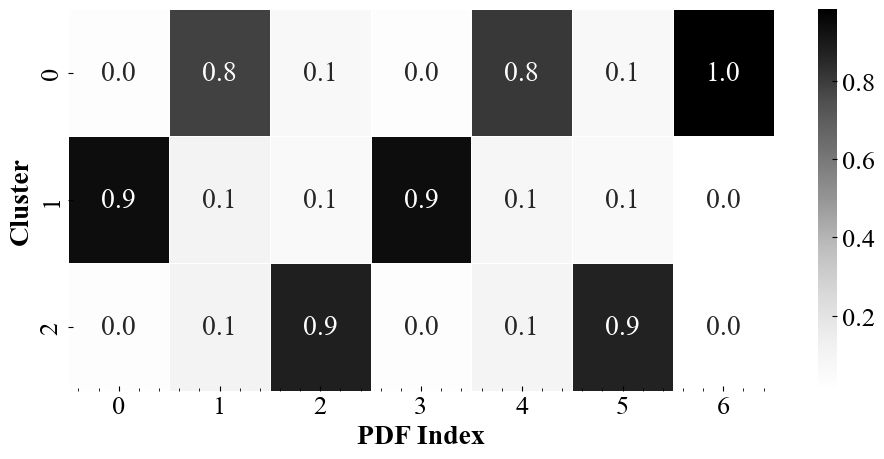

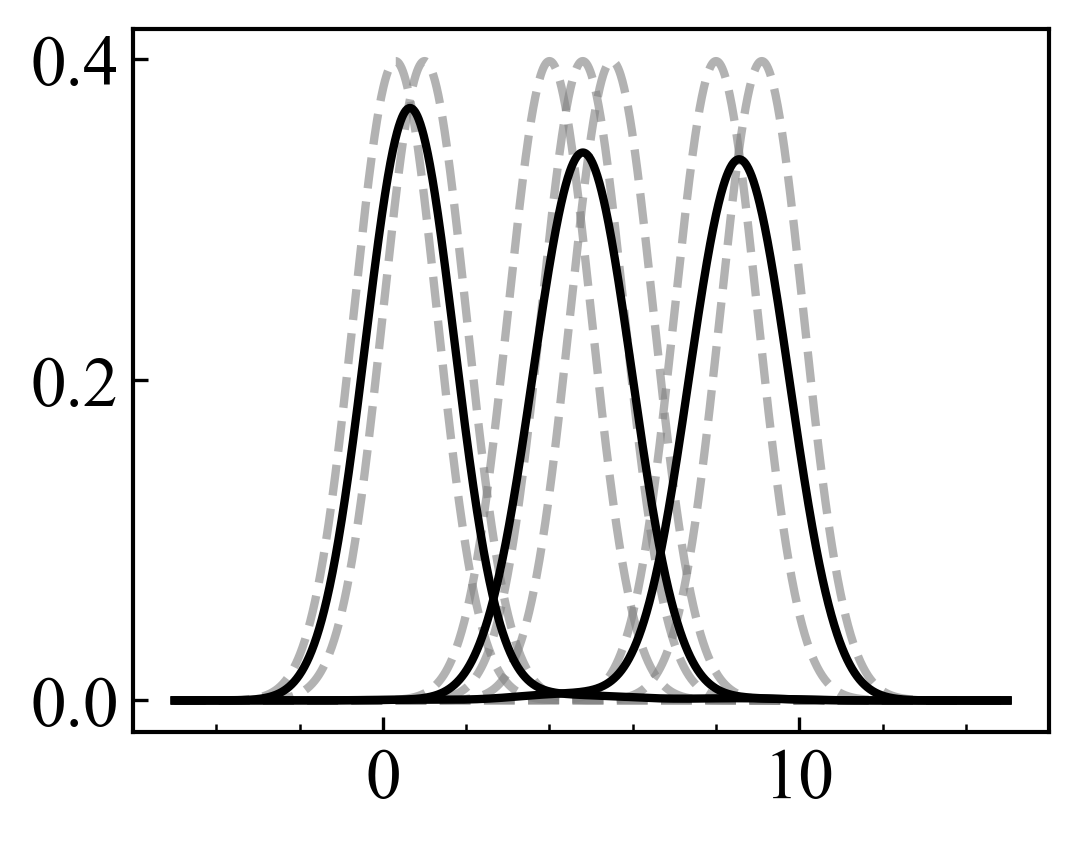

In [4]:
cluster=FCF.Model(
   grid_x=grid_x,
    num_clusters= 3,
    fuzziness= 2,
    max_iterations= 100,
    tolerance= 0.00001,
    distance_metric= 'L2',
)
cluster.fit(F_data)
U, Theta = cluster.get_results()

plotHeatmap_U(U)
plotPDF_Theta(grid_x, F_data, theta=Theta)